<a href="https://colab.research.google.com/github/mwidmoser/manifold-mixup/blob/master/code/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Manifold Mixup

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Torchvision imports
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data.dataset import Subset
from torch.utils.data import DataLoader

# Numpy and other stuff
import numpy as np
import random
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter

# Tensorboard
from torch.utils.tensorboard import SummaryWriter

torch.manual_seed(1234);
np.random.seed(1234);

# Check if we have a CUDA-capable device; if so, use it
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Will train on {}'.format(device))

Will train on cuda


In [81]:
# CIFAR10 transforms (random horizontal flipping + mean/std. dev. normalize)
cifar10_transforms = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
         
# Load full training data
ds_train = CIFAR10('./cifar', 
                 train=True, 
                 transform=cifar10_transforms, 
                 target_transform=None, 
                 download=True)

# Load full testing data 
ds_test = CIFAR10('./cifar', 
                 train=False, 
                 transform=cifar10_transforms,
                 target_transform=None, 
                 download=True)

lab = [ds_train[x][1] for x in range(len(ds_train))]

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def generate_train_indices(n_splits, train_size, lab):
    s = StratifiedShuffleSplit(
        n_splits=n_splits, 
        train_size=train_size, 
        test_size=None)
    
    return [i.tolist() for i, _ in s.split(lab, lab)]

In [0]:
classes = ['plane', 
           'car', 
           'bird', 
           'cat',
           'deer', 
           'dog', 
           'frog', 
           'horse', 
           'ship', 
           'truck']

In [0]:
def show_images(ds: torchvision.datasets.cifar.CIFAR10, 
                indices: list):
    
    assert np.max(indices) < len(ds)
    
    plt.figure(figsize=(9, len(indices)));
    for j,idx in enumerate(indices):
        plt.subplot(1,len(indices),j+1)
        plt.imshow(ds[idx][0].permute(1,2,0).numpy())
        plt.title('Label={}'.format(classes[ds[idx][1]]),fontsize=9)

## Tasks

The assignment is split into 4 parts: 

1. Writing the model definition
2. Writing the training code
3. Writing the testing code
4. Writing the *glue* code for training/testing

*First*, implement the following **convolutional neural network (CNN)**: It consists of 3 blocks and a simple linear classifier at the end.

My notation denotes the following:

- `Conv2D(in_channels, out_channels, kernel_size, padding)` - 2D Convolution
- `MaxPool(kernel_size, stride, padding)` - Max. pooling
- `AvgPool(kernel_size, stride, padding)` - Avg. pooling
- `Dropout(dropout_probability)` - Dropout layer
- `BatchNorm2D` - 2D batch normalization

All these operations can also be found in the [PyTorch documentaton](https://pytorch.org/docs/stable/index.html).

**Block 1**

```
Conv2D(  3,128,3,1) -> Batchnorm2D -> LeakyReLU(0.1)
Conv2D(128,128,3,1) -> Batchnorm2D -> LeakyReLU(0.1)
Conv2D(128,128,3,1) -> Batchnorm2D -> LeakyReLU(0.1)
MaxPool(2,2,0)
Dropout(0.5)
```
The output size at that point should be $N \times 128 \times 16 \times 16$.

**Block 2**

```
Conv2D(128,256,3,1) -> Batchnorm2D -> LeakyReLU(0.1)
Conv2D(256,256,3,1) -> Batchnorm2D -> LeakyReLU(0.1)
Conv2D(256,256,3,1) -> Batchnorm2D -> LeakyReLU(0.1)
MaxPool(2,2,0)
Dropout(0.5)
```
The output size at that point should be $N \times 128 \times 8 \times 8$.

**Block 3**

```
Conv2D(256,512,3,0) -> Batchnorm2D -> LeakyReLU(0.1)
Conv2D(512,256,1,0) -> Batchnorm2D -> LeakyReLU(0.1)
Conv2D(256,128,1,0) -> Batchnorm2D -> LeakyReLU(0.1)
AvgPool(6,2,0)
Dropout(0.5)
```
The output size at that point should be $N \times 128 \times 1 \times 1$.

**Classifier**

View the output of the last block as a $1 \times 128$ tensor and add a 
linear layer mapping from $\mathbb{R}^{128} \rightarrow \mathbb{R}^{10}$
(include bias).

```python
class ConvNet(nn.Module): 
    def __init__(self, num_classes=10):
      super(ConvNet, self).__init__()
      # YOUR CODE GOES HERE
      
    def forward(self, x):
      # YOUR CODE GOES HERE
      pass
```

In [0]:
class ConvNet(nn.Module): 
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        
        def make_block(conv_config, pooling_op=None, use_dropout=False):
            mlist = nn.ModuleList()
            for in_c, out_c, k_size, pad in conv_config:
                mlist.extend([
                    nn.Conv2d(in_c, out_c, k_size, padding=pad),
                    nn.BatchNorm2d(out_c),
                    nn.LeakyReLU(0.1)
                ])
            mlist.append(pooling_op)
            if use_dropout:
                mlist.append(nn.Dropout(0.5))
            return mlist

        self.block1 = make_block([
            [  3,128,3,1],
            [128,128,3,1],
            [128,128,3,1]], 
            nn.MaxPool2d(2,stride=2,padding=0), 
            use_dropout=True)
        
        self.block2 = make_block([
            [128,256,3,1],
            [256,256,3,1],
            [256,256,3,1]], 
            nn.MaxPool2d(2,stride=2,padding=0),
            use_dropout=True)

        self.block3 = make_block([
            [256,512,3,0],
            [512,256,1,0],
            [256,128,1,0]], 
            nn.AvgPool2d(6,stride=2,padding=0),
            use_dropout=False)
        
        self.classifier = nn.Linear(128,10)
    
    def forward(self, x, y=None, mixup_blocks=[False, False, False], mixup_alpha=1.0, random_mixup=False):
        mixup_lam  = None
        rand_layer = None

        if np.bitwise_or.reduce(mixup_blocks):
            assert y is not None, 'targets must be give if mixup is turned on'
            mixup_lam = np.random.beta(mixup_alpha, mixup_alpha) if mixup_alpha > 0 else 1

        if random_mixup:
            indices = [i for i, b in enumerate(mixup_blocks) if b]
            rand_layer = random.choice(indices) if indices else None

        if (mixup_blocks[0] and not random_mixup) or (random_mixup and rand_layer == 0):
            x, _, y = mixup(x, y, mixup_lam)

        for l in self.block1: x = l(x)

        if (mixup_blocks[1] and not random_mixup) or (random_mixup and rand_layer == 1):
            x, _, y = mixup(x, y, mixup_lam)

        for l in self.block2: x = l(x)

        if (mixup_blocks[2] and not random_mixup) or (random_mixup and rand_layer == 2):
            x, _, y = mixup(x, y, mixup_lam)

        for l in self.block3: x = l(x)

        x = x.view(x.size(0),-1)
        x = self.classifier(x)

        return x, y, mixup_lam

In [86]:
net = ConvNet(10)
out, _, _ = net(torch.rand(5,3,32,32))
print(out.size())

torch.Size([5, 10])


In [0]:
def mixup(x, y, lam):
    batch_size = x.size()[0]

    # index is a random permutation of [0, ..., 31]
    if torch.cuda.is_available():
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    # x[index, :] swaps the training samples
    # combine (mix) images depending on lambda
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    # plt.figure(figsize=(14,9))

    # plt.subplot(3, 3, 1)
    # plt.imshow(x[0].cpu().permute(1,2,0).numpy())
    # plt.subplot(3, 3, 2)
    # plt.imshow(x[index, :][0].cpu().permute(1,2,0).numpy())
    # plt.subplot(3, 3, 3)
    # plt.imshow(mixed_x[0].cpu().permute(1,2,0).numpy())

    # plt.subplot(3, 3, 4)
    # plt.imshow(x[1].cpu().permute(1,2,0).numpy())
    # plt.subplot(3, 3, 5)
    # plt.imshow(x[index, :][1].cpu().permute(1,2,0).numpy())
    # plt.subplot(3, 3, 6)
    # plt.imshow(mixed_x[1].cpu().permute(1,2,0).numpy())

    # plt.subplot(3, 3, 7)
    # plt.imshow(x[2].cpu().permute(1,2,0).numpy())
    # plt.subplot(3, 3, 8)
    # plt.imshow(x[index, :][2].cpu().permute(1,2,0).numpy())
    # plt.subplot(3, 3, 9)
    # plt.imshow(mixed_x[2].cpu().permute(1,2,0).numpy())
    
    return mixed_x, y_a, y_b

In [0]:
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [0]:
def train(model, device, train_loader, optimizer, epoch, mixup_blocks=[False, False, False], random_mixup=False):    
    model.train()
    
    epoch_loss = 0
    epoch_corr = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)

        output, target_b, lam = model(data, y=target, mixup_blocks=mixup_blocks, mixup_alpha=0.5, random_mixup=random_mixup)

        if lam is not None:
          loss   = mixup_criterion(F.cross_entropy, output, target, target_b, lam)
          if lam < 0.5:
            target = target_b
        else:
          loss = F.cross_entropy(output, target)

        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1, keepdim=True)
        epoch_corr += pred.eq(target.view_as(pred)).sum().item()
        
        epoch_loss += loss.item()

    train_accuracy = 100. * epoch_corr / len(train_loader.dataset)

    print('Train Epoch: {:2d} \tLoss: {:.6f} \tAccuracy: {:.2f}%'.format(epoch, epoch_loss, train_accuracy))
    return epoch_loss, train_accuracy

In [0]:
def test(model, device, test_loader):
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, _, _ = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(test_loader.dataset), test_accuracy))
    
    return test_loss, test_accuracy

Finally, write the *glue* code which iterates over `n_epochs` (e.g., 100) and, in each epoch, calls `train(...)` and `test(...)`.

In [91]:
train_indices = generate_train_indices(10, 500, lab)
ds_train_subset = Subset(ds_train, train_indices[1])
print(Counter([ds_train_subset[i][1] for i in range(len(ds_train_subset))]))

train_loader = torch.utils.data.DataLoader(
    ds_train_subset,
    batch_size=32,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    ds_test, 
    batch_size=64, 
    shuffle=False)

Counter({2: 50, 3: 50, 8: 50, 6: 50, 9: 50, 0: 50, 4: 50, 7: 50, 1: 50, 5: 50})


Train the model using **SGD** with a learning rate of 0.01 and momentum of 0.9 for 100 epochs.

After every 10th epoch, evaluate the current model on the testing data and print the current accuracy.

In [104]:
n_epochs = 100
iterations = 1 #5
accuracy = 0

writer = SummaryWriter()
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for _ in range(iterations):
    model = ConvNet().to(device)

    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 30, 0.1)

    for epoch in range(1, n_epochs + 1):
        # if random_mixup is set to True: one of the mixup_blocks set to True is chosen at random, 
        # e.g., `mixup_blocks=[True, True, False], random_mixup=True` applies mixup to block 0 or 1
        # if random_mixup is set to False: mixup is applied to all blocks which are set to True,
        # however, only one block/layer might make sense
        train_loss, train_acc = train(model, device, train_loader, optimizer, epoch, mixup_blocks=[True, True, True], random_mixup=True)

        if epoch % 10 == 0:
            test_loss, test_acc = test(model, device, test_loader)

            writer.add_scalar('Test loss', np.random.random(), epoch)
            writer.add_scalar('Test accuracy', test_acc, epoch)
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_acc))

        writer.add_scalar('Train loss', train_loss, epoch)
        writer.add_scalar('Train accuracy', train_acc, epoch)
        train_losses.append((epoch, train_loss))
        train_accuracies.append((epoch, train_acc))

        scheduler.step()
    accuracy += test_acc

print('Accuracy after {} iterations: {:.2f}%'.format(iterations, accuracy / iterations))

Train Epoch:  1 	Loss: 36.288062 	Accuracy: 13.80%
Train Epoch:  2 	Loss: 33.176906 	Accuracy: 24.60%
Train Epoch:  3 	Loss: 31.436140 	Accuracy: 31.80%
Train Epoch:  4 	Loss: 31.855899 	Accuracy: 32.40%
Train Epoch:  5 	Loss: 29.428623 	Accuracy: 36.20%
Train Epoch:  6 	Loss: 28.853993 	Accuracy: 37.60%
Train Epoch:  7 	Loss: 28.834341 	Accuracy: 37.60%
Train Epoch:  8 	Loss: 29.071528 	Accuracy: 40.60%
Train Epoch:  9 	Loss: 26.963935 	Accuracy: 41.00%
Train Epoch: 10 	Loss: 29.975726 	Accuracy: 38.40%

Test set: Average loss: 1.8564, Accuracy: 3405/10000 (34.05%)

Train Epoch: 11 	Loss: 27.279064 	Accuracy: 41.40%
Train Epoch: 12 	Loss: 27.643953 	Accuracy: 44.80%
Train Epoch: 13 	Loss: 25.627411 	Accuracy: 46.20%
Train Epoch: 14 	Loss: 27.410257 	Accuracy: 44.60%
Train Epoch: 15 	Loss: 26.171284 	Accuracy: 48.40%
Train Epoch: 16 	Loss: 24.602137 	Accuracy: 49.40%
Train Epoch: 17 	Loss: 24.081125 	Accuracy: 52.80%
Train Epoch: 18 	Loss: 25.789733 	Accuracy: 50.20%
Train Epoch: 19 	L

In [0]:
test(model, device, test_loader)


Test set: Average loss: 1.5100, Accuracy: 5130/10000 (51.30%)



# Visualize Training

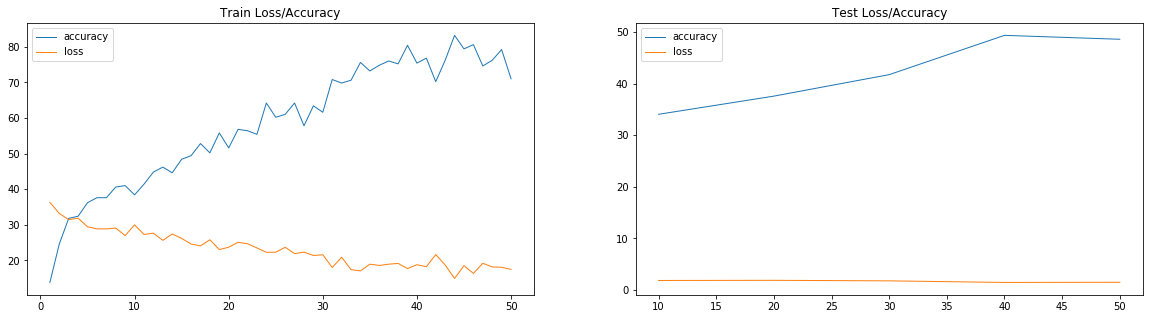

In [120]:
# plot loss and accuracy over time
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.title('Train Loss/Accuracy')
plt.plot([x for (x,y) in train_accuracies], [y for (x,y) in train_accuracies], linewidth=1, label='accuracy')
plt.plot([x for (x,y) in train_losses], [y for (x,y) in train_losses], linewidth=1, label='loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Test Loss/Accuracy')
plt.plot([x for (x,y) in test_accuracies], [y for (x,y) in test_accuracies], linewidth=1, label='accuracy')
plt.plot([x for (x,y) in test_losses], [y for (x,y) in test_losses], linewidth=1, label='loss')
plt.legend()

## Tensorboard

In [0]:
# clear any logs from previous runs
!rm -rf ./logs/ 

# run tensorboard
%load_ext tensorboard
%tensorboard --logdir=runs